# Example

Loading libraries. Units from *pint* library may be loaded through *logpli* as shown below or separately.

In [1]:
import logpli
import matplotlib.pyplot as plt
import numpy

In [2]:
plt.rc("figure", figsize=(16,9)) # bigger figures

In [3]:
un = logpli.un_default; # units

Some estimate of the initial carrier concentration is necessary for calculation ABC recombination constants later on.

In [4]:
# Estimate of initial carrier concentration
n0 = 3.9e21 * un.cm**-3

First, we load an *EstimateABC* class instance. We then load source data by *J_load_txt* function from a CSV file to variables *to* (time) and *Jo* (optical output).
Optical output is normalized by default, so it is dimensionless.

In [5]:
# Load estimation class
abc = logpli.EstimateABC(un=un);


# Load data from a text file.
# Time variable shall be increasing, although it does not have to be uniformly distribured.
# Optical output will be normalized if not indicated otherwise.
to, Jo = abc.J_load_txt("example.csv",# file name
                       tcol=0, Jcol=1, # columns for time variable and optical output variable in this file
                       tunit=un.ns,    # units for time in this file
                       skiprows=1,     # initial header rows to be skipped
                       delimiter=",",  # delimiter
                      );


# Values of optical output shall be positive. If they are not, zeros shall be discarded.
to, Jo = abc.remove_zero(to, Jo);

In *abc.plot* an instance of *logpli.Plotter* class is stored. It may be used for basic plots, as presented in this example.

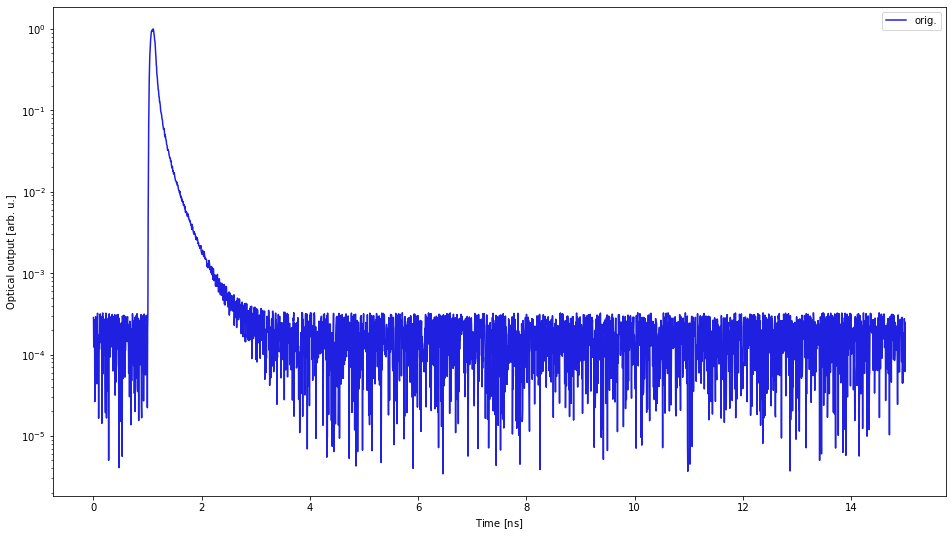

In [6]:
abc.plot.Je(to, Jo); # Plot of loaded data

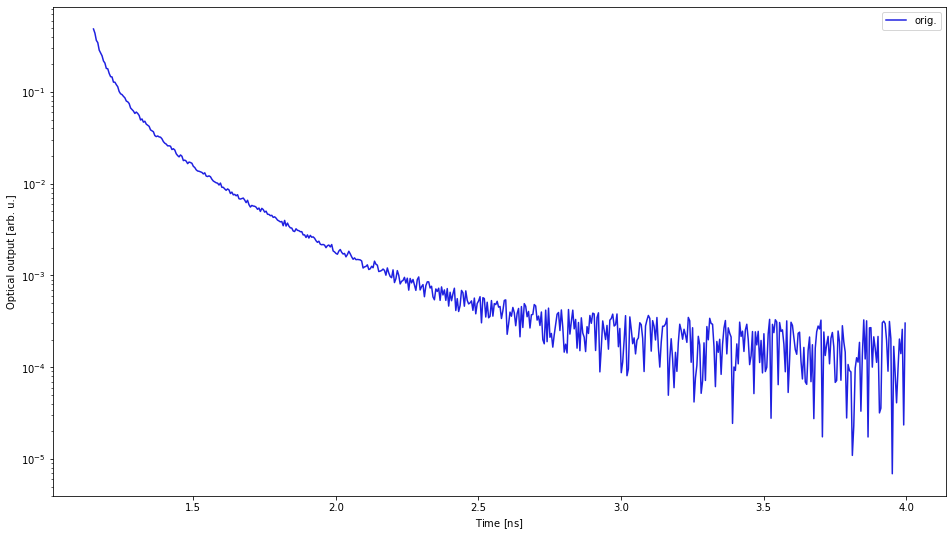

In [7]:
# Limit data to a given timeframe
# Optimally timeframe shall be limited to decay of the optical output,
# with initial excitation and final constant-level noise removed.
(te, Je) = abc.J_limit_t(to, Jo, 1.15*un.ns, 4.0*un.ns)
abc.plot.Je(te, Je); # Plot


Smoothing and noise removal (*J_smooth*).

Noise removal implemented in our library relies on the approximation of the noisy signal locally by a first-order polynomial on a given radius, measured in number of neighboring points. From this approximation it is possible to obtain a function value and its derivative.

For a relatively clear signal, radius of few neighbor is sufficient, but for a noisy signal the radius may go up to several dozen of neighbors.

Since the relative noise level varies significantly for time-resloved luminescence measurements, our library allows for variable smoothing radius. The radii (parameter *radius*) may be specified at given time moments (parameter *tradius*). The procedure will automatically interpolate the radius to change gradually between time points.
Since in time-resloved luminescence the signal is generally decreasing and the relative noise level increases with decreasing signal, it is often easier to specify values of threshold optical output values and to specify the radii at corresponding times.
This may be done by procedure *J_tradius*, which automatically finds the time moments for which the optical output falls below certain values, as presented in the example below.

This algorithm is supposed to be performed multiple times to obtain possibly smooth results. The parameter *iters* determines number of repetitions to be performed.
One shall start from a small number of iterations (1, 2) and then increase it until reaching satisfactory smoothness.

Smoothed values would be stored in *ts0* and *Js0*, and the derivative of *Js0* as *dJs0*.

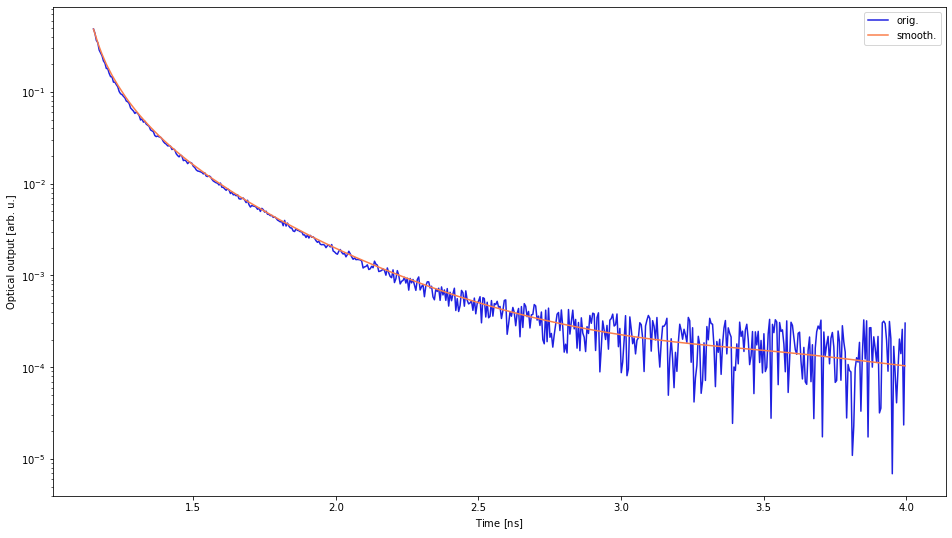

In [8]:
# Smoothing and noise removal.
# 
(ts0, Js0, _, dJs0) = abc.J_smooth(te=te, Je=Je,
                tradius=abc.J_tradius(te, Je, [1,  0.1, 0.01, 0.001]),# threshold Je0 values for radii adjustment
                radius=[2, 10, 20, 45], # radii for threshold Je given above
                iters=3,
                                     )

abc.plot.JeJs(te, Je, ts0, Js0);


In an ideal case, we expect the optical output to become exponential decay after some time after the excitation. Unfortunately, due to some noise level (with a positive average value), this exponential decay cannot be observed, which negatively affect the following analysis. Thus, we will try to determine this noise level *J_tail* and to subtract it from the smoothed signal.

This procedure is performed by *J_tail_replace*. This procedure needs a parameter *tmin*, which roughly corresponds to the time where the exponential decay may already be observed, but the noise level is not reached yet. The procedure will determine this exponential decay and switch to it at time *tswitch*.

If *J_tail* is non-positive, then the procedure failed. If this is the case, one shall try to change *tmin* parameter. Alternatively, this procedure may be ignored in such case, as presented in code below.

Smoothed data with subtracted noise level is denoted as *ts*, *Js*, with derivative *dJs*.

tswitch: 1.9856618872957652 nanosecond
Tail: 0.0001621113929741412 dimensionless


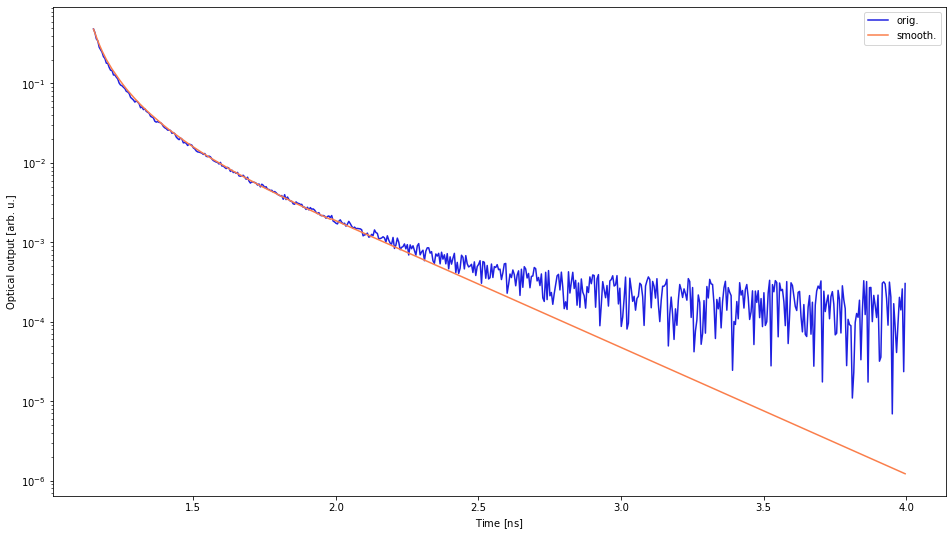

In [9]:
# Convert tailing noise to exponential decay
Js, dJs, J_tail, tswitch = abc.J_tail_replace(ts0, Js0, dJs0,
                                                tmin=1.75*un.ns, # approximate location of switching to exponential decay
                                               );
print("tswitch:", tswitch); # moment of switching to exponential decay
print("Tail:", J_tail); # noise level found; it is subtracted from the smoothed result
ts = ts0; # time variable is not affected

# If J_tail is negative, then tmin is too high and no exponential decay or noise level was found.
# If this is the case, either adjust tmin or ignore the procedure as indicated below.
if(J_tail < 0):
    print("Tail is negative and it is ignored.")
    Js = Js0;
    dJs = dJs0;

# Plot
abc.plot.JeJs(te, Je, ts, Js);

Then, we finally calculate negative logarithmic time derivative *RLs* and we plot it against *Js* and square-root of *Js*, which correspond to mono-molecular and bi-molecular radiative recombination regime, respectively.

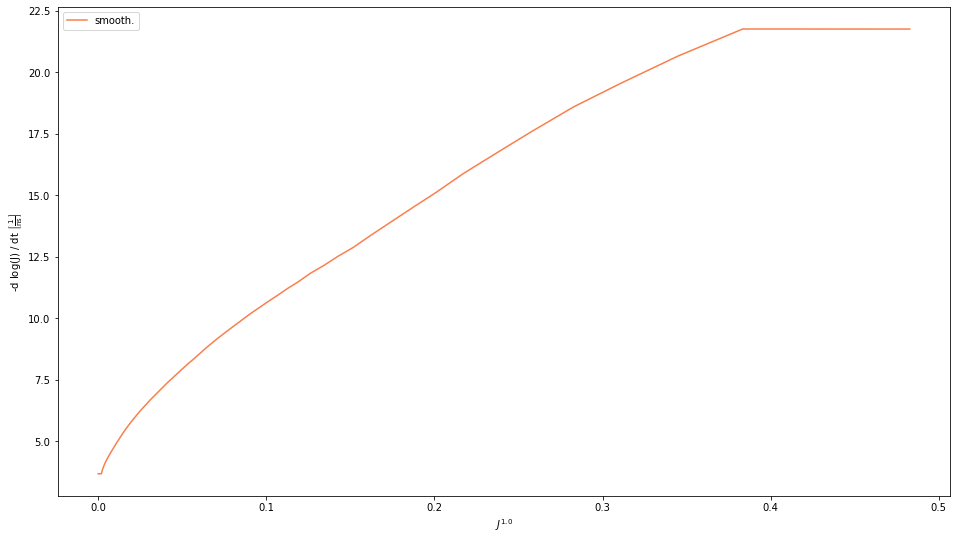

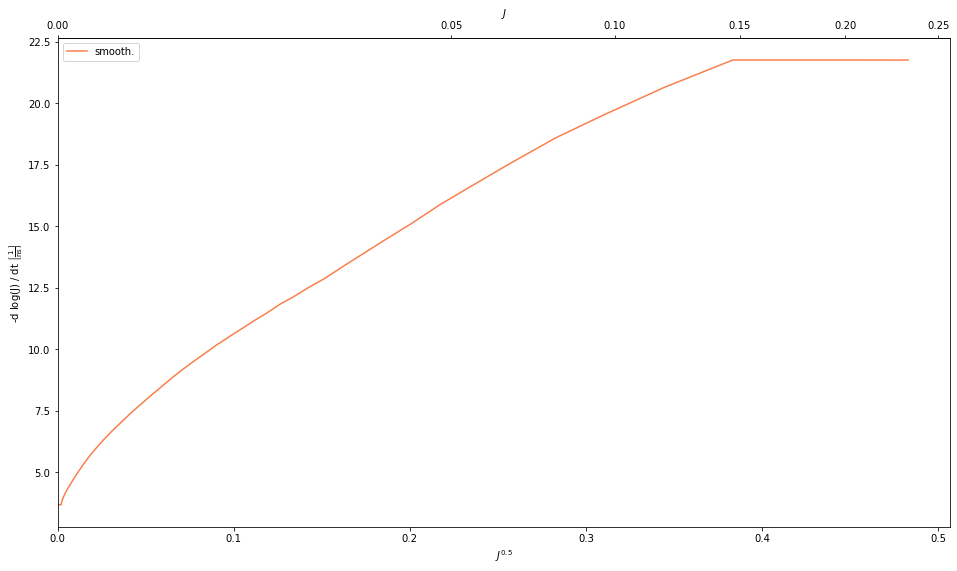

In [10]:
# Calculate and plot of logarithmic time derivative of the normalized optical output (RL)
RLs = -dJs / Js;

# Plot.
abc.plot.RLs(Js, RLs,
             mu=1, # 1 or 2
            )
plt.show();

# Plot.
abc.plot.RLs(Js, RLs,
             mu=2, # 1 or 2
            )
plt.show();


The function $r_L = -\frac{d \log(J)}{dt}$ plotted above is a basis of the estimation to follow. It is important to note that the argument on the plots above correspods to inverted time-scale in a sense, as $J$ decreases with time.

The domain of $r_L$ is a subset of $[0,1]$.
It will be divided further into three subintervals:
$(P_{J,0}, P_{J,1})$,
$(P_{J,1}, P_{J,2})$,
$(P_{J,2}, P_{J,3})$.
On first and second subintervals, we will perform the polynomial fits of $r_L \approx p_i(y)$ for $y = J, i=1$ and $y=\sqrt{J}, i=2$, respectively.
We will obtain coefficients $\alpha_i, \beta_i, \gamma_i$ so that $p_i(y) = \alpha + \beta y +\gamma y^2$.

The third interval, $(P_{J,2}, P_{J,3})$, will be ignored. It is often the case that at the beginning of the decay there are some residuals of the excitation process and also the smoothing procedure in this part may be inaccurate close to $J=1$.

The procedure described above will be performed by function *RL_fit*.
By default this function, given $J$ and $r_L$, tries to determine the dicision points $P_{J,1}$, $P_{J,2}$ automatically.
However, if the automatic fit is not satisfactory, it may be amended by additional parameters:

* *pull* --- This parameter may be used if the discarded interval $(P_{J,2}, P_{J,3})$ is too big or too small. If it is too big, positive values will shift $P_{J,2}$ more to the right increasingly with the value. Negative values will shift $P_{J,2}$ to the left.
* *PJ2* --- If automatic estimation of $P_{J,2}$ is unsatisfactory, it may be fixed to a given value. $P_{J,1}$ will still be estimated automatically
* *PJ1* --- Additionally, if $P_{J,2}$ is fixed, then $P_{J,1}$ may be fixed as well. Note that it is not possible to fix $P_{J,1}$ and autodetect $P_{J,2}$.

The obtained polynomial fits will be available by *res.f_RLfit* function.

In [11]:
# Find division points for RL:
# (PJ0, PJ1) --- mono-molecular regime (mu = 1)
# (PJ1, PJ2) --- bi-molecular regime (mu = 2)
# (PJ2, PJ3) --- discarded part (model do not apply)
# P1 and P2 may be fixed if necessary
# Fitting procedure will also be performed, coefficients are saved in "res" structure

#res = abc.RL_fit(Js, RLs); # auto-detect invervals
res = abc.RL_fit(Js, RLs, pull = -17); # auto-detect intervals, but move the fitting range more to the left
#res = abc.RL_fit(Js, RLs, pull = 10); # auto-detect intervals, but move the fitting range more to the right
#res = abc.RL_fit(Js, RLs, PJ2 = 0.35*un.dimensionless); # fix PJ2, autodetect PJ1
#res = abc.RL_fit(Js, RLs, PJ1 = 0.003*un.dimensionless, PJ2 = 0.22*un.dimensionless); # fix PJ2 and PJ1
abc.print.RL_fit_details(res);

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

To plot the fitted polynomial approximations, we need arguments spanning two intervals $(P_{J,0}, P_{J,1})$,
$(P_{J,1}, P_{J,2})$, denoted *J1* and *J2*.

In [12]:
# Ranges for plotting:
J1 = numpy.linspace(res.PJ0, res.PJ1, 500) * Js.units; # mono-molecular regime
J2 = numpy.linspace(res.PJ1, res.PJ2, 500)[1:] * Js.units;  # bi-molecular regime

Then we plot $r_L$ and obtained fits for inspection. First we perform a plot corresponding to mono-molecular regime.
We generally expect the mono-molecular regime to be obtained in the *fit 1* region and bi-molecular regime within *fit 2* region.

As it is often the case for sufficiently-high excitation, in this example, the bi-molecular region is much more prominent on the $r_L$ plot. This allows us to estimate the ABC recombination constants for the bi-molecular regime.

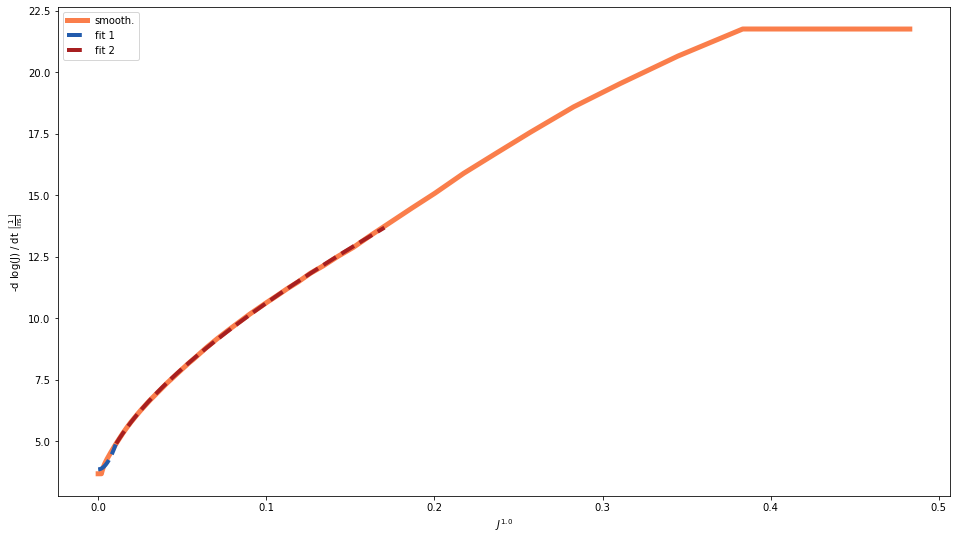

In [13]:
mu=1; # mono-particular regime plot
abc.plot.RLsRLf2(Js**(1/mu), RLs, J1**(1/mu), res.f_RLfit(J1), J2**(1/mu), res.f_RLfit(J2), mu=mu)

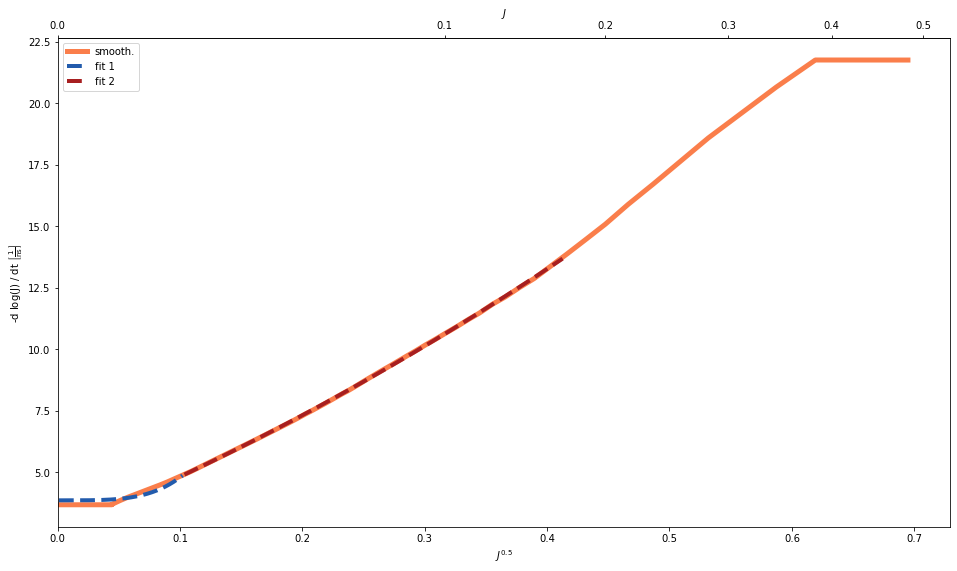

In [14]:
mu=2; # bi-particular regime plot
abc.plot.RLsRLf2(Js**(1/mu), RLs, J1**(1/mu), res.f_RLfit(J1), J2**(1/mu), res.f_RLfit(J2), mu=mu)


Finally, we estimate the ABC constants. First, for the mono-molecular regime:

In [15]:
# Print polynomial coefficients and ABC coefficients for mono-molecular regime
abc.print.poly_coefs(alpha=res.alpha1, beta=res.beta1, gamma=res.gamma1);
abc_coefs=abc.abc_from_coefs(alpha=res.alpha1, beta=res.beta1, gamma=res.gamma1, mu=1,
                             n0=n0)
abc.print.abc(**abc_coefs._asdict())

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

And then the ABC constants for the bi-molecular regime:

In [16]:
# Print polynimoal coefficients and ABC coefficients for bi-molecular regime
abc.print.poly_coefs(alpha=res.alpha2, beta=res.beta2, gamma=res.gamma2);
abc_coefs=abc.abc_from_coefs(alpha=res.alpha2, beta=res.beta2, gamma=res.gamma2, mu=2,
                             n0=n0)
abc.print.abc(**abc_coefs._asdict())

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

This step completes the analysis.